In [3]:
import numpy as np
import sklearn
import pandas as pd
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
from sklearn.metrics import r2_score
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [127]:
class MGUA:
    def __init__(self, Q=3, C=0.99, I=3, model=LinearRegression(normalize=True), X_train=None, y_train=None, buf_coef=None, buf=None):
        self.Q = Q #размер буфера
        self.C = C #порог корреляции
        self.I = I #количество итераций
        self.model = model #model = LinearRegression(normalize=True)
        self.EPS = 1e-14
        self.X_train = X_train
        self.y_train = y_train
        self.buf_coef = buf_coef
        self.buf = buf
        self.column_indexes = [] #индексы колонок, использованных в каждой модели
        
    def fit(self, X, y):
        N = X.shape[0]
        M = X.shape[1]
        buf_val = 0
        for i in range(M):
            print(i, ' / ', M)
            for j in range(i+1, M):
                X_train = X.iloc[:, [i, j]]
                self.model.fit(X_train, y)
                pred = self.model.predict(X_train) #Попробовать тут Х?
                if buf_val == 0:
#                     print(type(pred))
                    buf = [pred] #buf[0] = [pred]???
                    buf_coef = [[[i, j]]]
                    buf_val += 1
                else:
                    buf_corr = [corr(col, pred.reshape(-1, )) for col in buf[0].T]
                    if buf_val<self.Q and max(buf_corr)-self.C < self.EPS:
                        buf[0] = np.c_[buf[0], pred]
                        buf_coef[0].append([i, j])
                        buf_val += 1
                    elif buf_val>=self.Q and max(buf_corr)<self.C:
                        buf_r2 = [r2_score(y, buf[0][:, col]) for col in range(self.Q)]
                        if r2_score(y, pred) > min(buf_r2):
                            buf[0] = np.delete(buf[0], buf_r2.index(min(buf_r2)), axis = 1)
                            del buf_coef[0][buf_r2.index(min(buf_r2))]
                            buf[0] = np.c_[buf[0], pred]
                            buf_coef[0].append([i, j])

        for k in range(1, self.I):
            print("iter = ", k)
            buf_val = 0
            X_train = X.iloc[:, [0]]
            X_train = X_train.assign(new = buf[k-1][:, 0])
            self.model.fit(X_train, y)
            pred = self.model.predict(X_train) 
            
            buf.append(pred)
            buf_coef.append([[0, 0]])
            buf_val += 1
            for i in range(M):
#                 print('i = ', i)
                for j in range(1, buf[k-1].shape[1]):
                    X_train = X.iloc[:, [i]]
                    X_train = X_train.assign(new = buf[k-1][:, j])
                    self.model.fit(X_train, y)
                    pred = self.model.predict(X_train) 

                    buf_corr = [corr(col, pred.reshape(-1, )) for col in buf[k].T]
#                     if buf_val>=self.Q:
#                         print('buf_val=', buf_val, 'max(buf_corr)=', max(buf_corr), max(buf_corr)<self.C)
                    if buf_val<self.Q and max(buf_corr)-self.C < self.EPS:
#                         print('1. (i, j) = ', i, j)
                        buf[k] = np.c_[buf[k], pred]
                        buf_coef[k].append([i, j])
                        buf_val += 1
                    elif buf_val>=self.Q and max(buf_corr)<self.C:
                        buf_r2 = [r2_score(y_train, buf[k][:, col]) for col in range(self.Q)]
                        if r2_score(y_train, pred) > min(buf_r2):
#                             print('(i, j) = ', i, j)
                            buf[k] = np.delete(buf[k], buf_r2.index(min(buf_r2)), axis = 1)
                            del buf_coef[k][buf_r2.index(min(buf_r2))]
                            buf[k] = np.c_[buf[k], pred]
                            buf_coef[k].append([i, j])
        self.buf_coef = buf_coef
        self.buf = buf
        self.X_train = X
        self.y_train = y
        return buf_coef
    
    def predict(self, X):
        result = []
        index = []
        for i in range(len(self.buf_coef[-1])): #может быть последний буфер не полностью заполнен, тогда меньше...
            ind_pred = i
            index.append([])
            for k in reversed(range(self.I)):
                index[i].append(self.buf_coef[k][ind_pred])
                ind_pred = self.buf_coef[k][ind_pred][1]
            X_t = self.X_train.iloc[:, index[i][-1]]
            self.model.fit(X_t, self.y_train)
            pred = self.model.predict(X.iloc[:, index[i][-1]])
            for k in range(1, self.I):
                X_t = self.X_train.iloc[:, [index[i][self.I-1-k][0]]]
                X_t = X_t.assign(new = self.buf[k-1][:, index[i][self.I-1-k][1]])
                self.model.fit(X_t, self.y_train)
                X_pred = X.iloc[:, [index[i][self.I-1-k][0]]]
                X_pred = X_pred.assign(new = pred)
                pred = self.model.predict(X_pred)
            result.append(pred)
        
        for col in index:
            self.column_indexes.append(set([row[0] for row in col]) | set([col[-1][1]]))
            
        return result #Q столбцов - Q предсказаний
    
    def save_json(self, filepath):
        dict_ = {}
        dict_['Q'] = self.Q
        dict_['C'] = self.C
        dict_['I'] = self.I
#         dict_['model'] = self.model
        dict_['X_train'] = self.X_train.to_numpy().tolist() if self.X_train is not None else 'None'
        dict_['y_train'] = self.y_train.to_numpy().tolist() if self.y_train is not None else 'None'
        dict_['buf_coef'] = np.array(self.buf_coef).tolist() if self.buf_coef is not None else 'None'
        dict_['buf'] = np.array(self.buf).tolist() if self.buf is not None else 'None'
        
        # Creat json and save to file
        json_txt = json.dumps(dict_, indent=4)
        with open(filepath, 'w') as file:
            file.write(json_txt)
            
            
    # A method for loading data from JSON file
    def load_json(self, filepath):
        with open(filepath, 'r') as file:
            dict_ = json.load(file)
            
        self.Q = dict_['Q']
        self.C = dict_['C']
        self.I = dict_['I']
#         self.model = dict_['model']
        self.X_train = pd.DataFrame(dict_['X_train']) if dict_['X_train'] != 'None' else None
        self.y_train = pd.DataFrame(dict_['y_train']) if dict_['y_train'] != 'None' else None
        self.buf_coef = np.asarray(dict_['buf_coef']) if dict_['buf_coef'] != 'None' else None
        self.buf = np.asarray(dict_['buf']) if dict_['buf'] != 'None' else None
        


In [5]:
def corr(x, y):
    up = sum(x*y)
    down = math.sqrt(sum(x*x)*sum(y*y))
    return up/down

## Как сохранить обученную модель

In [ ]:
filepath = "mylogreg.json"

# Create a model and train it
mylogreg = MGUA(X_train=Xtrain, Y_train=Ytrain)
mylogreg.save_json(filepath)

# Create a new object and load its data from JSON file
json_mylogreg = MGUA()
json_mylogreg.load_json(filepath)
json_mylogreg

In [63]:
glass = pd.read_csv('glass_/GLASS_matrix_alphabet_NNdt*_1and2and3chains.csv', sep=',', header=None)
y_glass = pd.read_csv('glass_/GLASS_y.csv')

In [64]:
glass.head(3)

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
mgua = MGUA(Q=4, C=0.997, I=5, model=LinearRegression(normalize=True))

In [25]:
long = MGUA(4, 0.997, 5, LinearRegression(normalize=True))

In [74]:
train_size = int(0.7 * glass.shape[0])

X_train = glass[:][:train_size]
y_train = y_glass[:][:train_size]
X_test = glass[:][train_size:]
y_test = y_glass[:][train_size:]
coef = mgua.fit(X_train, y_train)
# result = long.fit(X_train, y_train)

In [79]:
json_file = "glass_/model__GLASS_matrix_alphabet_NNdt*_1and2and3chains.json"
# mylogreg = MGUA(X_train=Xtrain, Y_train=Ytrain)
mgua.save_json(json_file)

In [124]:
mgua_glass = MGUA()
mgua_glass.load_json(json_file)
mgua_glass

In [125]:
res = mgua_glass.predict(X_test)

In [126]:
mgua_glass.column_indexes

[{0, 1, 2, 6}, {0, 1, 6, 55}, {0, 6, 17, 55}, {2, 6, 55}]

In [106]:
a = np.array([1, 2]).reshape(2, )

In [122]:
set([a[1]])

{2}

In [254]:
np.count_nonzero(glass)

1460

## Результат на glass_/GLASS_matrix_NNdt*_1and2and3chains.csv

In [60]:
result

[[[28, 244], [37, 46], [39, 1094], [249, 5293]],
 [[99, 2], [99, 3], [213, 2], [2982, 2]],
 [[99, 2], [102, 3], [2865, 3], [5085, 1]],
 [[0, 0], [0, 1], [0, 2], [0, 3]],
 [[0, 0], [0, 1], [0, 2], [0, 3]]]

In [61]:
reslong = long.predict(X_test)

In [62]:
for i in range(4):
    print(r2_score(y_test, reslong[i]))

-1.379672563059542
-0.7505992651322624
-1.073322722462779
-1.534577713436176


In [55]:
np.count_nonzero(glass)

9101

Визуализация результатов:

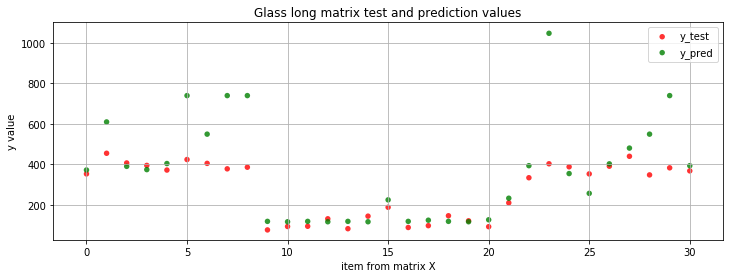

In [236]:
data = ((np.arange(y_test.shape[0]), y_test.to_numpy().reshape(-1)), (np.arange(y_test.shape[0]), reslong[1].reshape(-1)))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(4)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Glass long matrix test and prediction values')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

## Результат на glass_/GLASS_matrix_alphabet_NNdt*_1and2and3chains.csv

In [77]:
res = mgua.predict(X_test)

In [70]:
for i in range(4):
    print(r2_score(y_test, res[i]))

0.9287023586642775
0.8399777455671995
0.829126991426675
0.7829653377845821


In [71]:
mgua.buf_coef

[[[0, 6], [0, 35], [2, 6], [6, 55]],
 [[1, 2], [1, 3], [2, 3], [17, 3]],
 [[0, 0], [0, 1], [0, 3], [2, 2]],
 [[0, 0], [0, 1], [0, 2], [2, 3]],
 [[0, 0], [0, 1], [0, 2], [2, 3]]]

In [57]:
np.count_nonzero(glass)

1460

In [118]:
json_file = "model__GLASS_matrix_alphabet_NNdt*_1and2and3chains.json"
# mylogreg = MGUA(X_train=Xtrain, Y_train=Ytrain)
mgua.save_json(json_file)

In [119]:
mgua1 = MGUA(model=LinearRegression(normalize=True))
mgua1.load_json(json_file)
res1 = mgua1.predict(X_test)

In [212]:
for i in range(4):
    print(r2_score(y_test, res1[i]))

0.9287023586642775
0.8399777455671995
0.829126991426675
0.7829653377845821


Визуализация результатов:

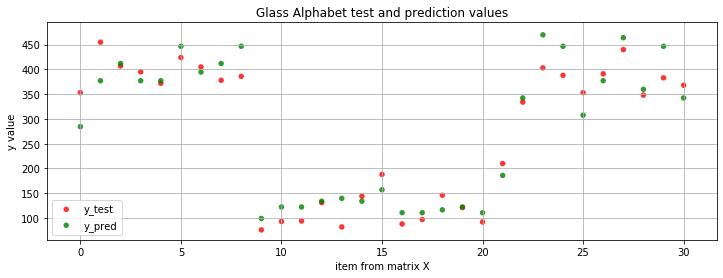

In [232]:
data = ((np.arange(y_test.shape[0]), y_test.to_numpy().reshape(-1)), (np.arange(y_test.shape[0]), res1[0].reshape(-1)))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(4)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Glass Alphabet test and prediction values')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

# Выборка SOIL

In [16]:
soil = pd.read_csv('SOIL/soil-1-1_matrix_alphabet_NNdt*_1and2and3chains.csv', sep=',', header=None)
y_SOIL = pd.read_csv('SOIL/soil-1-1_y.csv')
y_SOIL.columns

Index(['>  <logKoc(exp)> ', '>  <logKoc(cal)> ', '>  <logKow(cal)> '], dtype='object')

In [188]:
soil

,0,1,2,3,4,5,6,7,8,9,...,467,468,469,470,471,472,473,474,475,476
0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y_soil0 = pd.DataFrame(y_SOIL.loc[:, '>  <logKoc(exp)> '])
y_soil0

,> <logKoc(exp)>
0,1.40
1,1.43
2,1.95
3,1.94
4,1.57
...,...
323,2.16
324,1.98
325,1.87
326,1.80


## Линейная регрессия:

In [18]:
soil_mgua = MGUA(6, 0.997, 7, LinearRegression(normalize=True))

In [39]:
train_size = int(0.7 * soil.shape[0])


In [40]:
X_train = soil[:][:train_size]
y_train = y_soil0[:][:train_size]
X_test = soil[:][train_size:]
y_test = y_soil0[:][train_size:]
# model_soil = soil_mgua.fit(X_train, y_train)

In [21]:
soil_pred = soil_mgua.predict(X_test)

In [22]:
for i in range(4):
    print(r2_score(y_test, soil_pred[i]))

0.2286329553195494
0.25724556100661455
0.19309654049009173
0.1958328024154703


In [23]:
model_soil

[[[1, 172], [7, 9], [9, 40], [9, 172], [9, 270], [34, 172]],
 [[90, 1], [90, 3], [90, 4], [252, 1], [285, 1], [400, 1]],
 [[1, 5], [22, 2], [56, 5], [90, 3], [90, 4], [90, 5]],
 [[22, 3], [56, 4], [69, 3], [69, 4], [69, 5], [252, 5]],
 [[0, 0], [0, 4], [400, 2], [451, 1], [451, 2], [451, 5]],
 [[0, 1], [0, 2], [0, 4], [0, 5], [69, 3], [72, 3]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]]

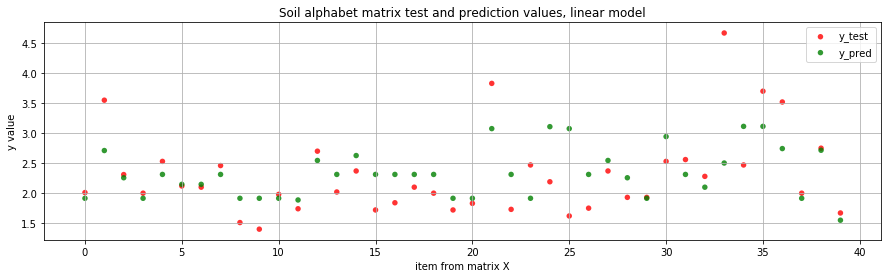

In [24]:
data = ((np.arange(y_test[:40].shape[0]), y_test.to_numpy().reshape(-1)[:40]), (np.arange(y_test[:40].shape[0]), soil_pred[2].reshape(-1)[:40]))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(4)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Soil alphabet matrix test and prediction values, linear model')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

## Гребневая регрессия:

In [25]:
from sklearn.linear_model import Ridge

In [248]:
ridge_soil_mgua = MGUA(6, 0.997, 7, Ridge(normalize=True, alpha=1))

In [250]:
ridge_model_soil = ridge_soil_mgua.fit(X_train, y_train)

In [155]:
ridge_soil_pred = ridge_soil_mgua.predict(X_test)

In [156]:
for i in range(ridge_soil_mgua.Q):
    print(r2_score(y_test, ridge_soil_pred[i]))

-0.210178133127485
-0.2788644721236484
-0.4246583550672902
-0.479700770484643
-0.412956734338104
-0.3057943165826933


In [157]:
ridge_model_soil

[[[0, 9], [1, 22], [19, 22], [33, 55], [55, 110], [79, 88]],
 [[0, 0], [0, 1], [1, 3], [6, 2], [47, 3], [146, 4]],
 [[0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [1, 2]],
 [[0, 0], [0, 1], [0, 3], [0, 4], [1, 3], [4, 2]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [1, 2]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 2]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 2]]]

В данной модели размер буфера = 6, количество итераций = 7. Можно заметить, что последние 3 строки отличаются одной цифрой, это значит, что можно количество итераций сократить до 5, а то и до 4х без потери качества (которого и так нет). Аналогичное предположение можно сделать относительно столбцов матрицы, то есть размера буфера. Или можно изменить порог корреляции на 0.9990

In [27]:
ridge_soil_mgua = MGUA(6, 0.9990, 9, Ridge(normalize=True, alpha=1))

In [28]:
ridge_model_soil = ridge_soil_mgua.fit(X_train, y_train)

0  /  477
1  /  477
2  /  477
3  /  477
4  /  477
5  /  477
6  /  477
7  /  477
8  /  477
9  /  477
10  /  477
11  /  477
12  /  477
13  /  477
14  /  477
15  /  477
16  /  477
17  /  477
18  /  477
19  /  477
20  /  477
21  /  477
22  /  477
23  /  477
24  /  477
25  /  477
26  /  477
27  /  477
28  /  477
29  /  477
30  /  477
31  /  477
32  /  477
33  /  477
34  /  477
35  /  477
36  /  477
37  /  477
38  /  477
39  /  477
40  /  477
41  /  477
42  /  477
43  /  477
44  /  477
45  /  477
46  /  477
47  /  477
48  /  477
49  /  477
50  /  477
51  /  477
52  /  477
53  /  477
54  /  477
55  /  477
56  /  477
57  /  477
58  /  477
59  /  477
60  /  477
61  /  477
62  /  477
63  /  477
64  /  477
65  /  477
66  /  477
67  /  477
68  /  477
69  /  477
70  /  477
71  /  477
72  /  477
73  /  477
74  /  477
75  /  477
76  /  477
77  /  477
78  /  477
79  /  477
80  /  477
81  /  477
82  /  477
83  /  477
84  /  477
85  /  477
86  /  477
87  /  477
88  /  477
89  /  477
90  /  477
91  /  47

In [29]:
ridge_soil_pred = ridge_soil_mgua.predict(X_test)

In [30]:
for i in range(ridge_soil_mgua.Q):
    print(r2_score(y_test, ridge_soil_pred[i]))

0.08177162849768471
0.020645658477622564
0.09943557618973287
0.08447732368765415
0.22697584837998863
-8.06018415947066


In [32]:
ridge_model_soil

[[[1, 172], [7, 9], [9, 20], [9, 68], [9, 172], [79, 172]],
 [[1, 1], [1, 4], [20, 1], [90, 1], [172, 1], [400, 1]],
 [[1, 3], [1, 5], [22, 3], [172, 3], [342, 3], [401, 3]],
 [[1, 2], [69, 4], [172, 2], [236, 2], [252, 2], [463, 1]],
 [[172, 1], [400, 1], [401, 1], [401, 4], [410, 4], [463, 4]],
 [[1, 1], [1, 3], [172, 1], [174, 1], [236, 1], [450, 1]],
 [[150, 2], [150, 4], [172, 1], [244, 1], [401, 5], [426, 3]],
 [[0, 5], [1, 4], [1, 5], [69, 3], [90, 4], [172, 3]],
 [[172, 1], [236, 1], [236, 4], [244, 1], [287, 4], [401, 2]]]

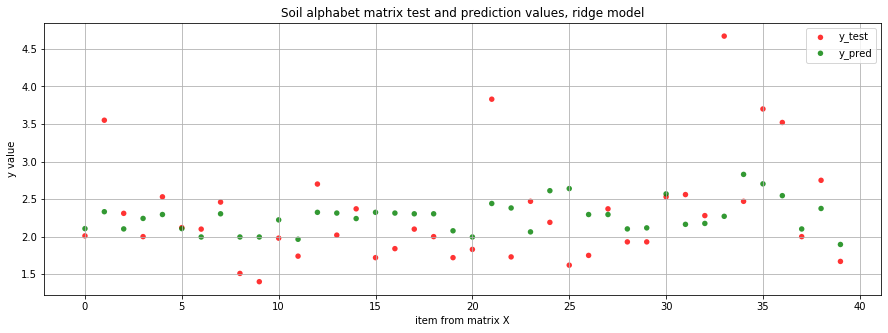

In [31]:
# data = ((np.arange(40, 80), y_test.to_numpy().reshape(-1)[40:80]), (np.arange(40, 80), ridge_soil_pred[2].reshape(-1)[40:80]))
data = ((np.arange(y_test[:40].shape[0]), y_test.to_numpy().reshape(-1)[:40]), (np.arange(y_test[:40].shape[0]), ridge_soil_pred[2].reshape(-1)[:40]))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Soil alphabet matrix test and prediction values, ridge model')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

Заметим, что теперь значения в буфере не такие постоянные, значит, вероятно, модель недообучилась, поэтому увеличим еще буфер и количество итераций:

In [178]:
ridge_soil_mgua = MGUA(Q=10, C=0.9990, I=20, model=Ridge(normalize=True, alpha=1))

In [273]:
ridge_model_soil = ridge_soil_mgua.fit(X_train, y_train)

In [180]:
ridge_soil_pred = ridge_soil_mgua.predict(X_test)

In [181]:
for i in range(ridge_soil_mgua.Q):
    print(r2_score(y_test, ridge_soil_pred[i]))

-0.15610666458748268
-0.12135160910713494
-0.0731839961617835
-0.10593241987426061
-0.034964292555522025
-0.06638687176919711
-0.17641937483040215
-0.07906569589561152
-0.13986302891793656
-0.08951455389765473


In [182]:
pd.DataFrame(ridge_model_soil)

,0,1,2,3,4,5,6,7,8,9
0,"[1, 6]","[1, 9]","[1, 22]","[9, 19]","[9, 22]","[9, 28]","[9, 33]","[9, 54]","[9, 178]","[22, 88]"
1,"[1, 3]","[1, 7]","[1, 9]","[6, 1]","[9, 2]","[22, 5]","[22, 6]","[60, 6]","[88, 7]","[144, 6]"
2,"[1, 6]","[1, 7]","[9, 1]","[22, 7]","[22, 9]","[28, 7]","[28, 9]","[55, 2]","[88, 3]","[451, 3]"
3,"[9, 1]","[9, 9]","[22, 5]","[55, 5]","[60, 6]","[178, 1]","[178, 5]","[178, 6]","[240, 5]","[292, 1]"
4,"[6, 5]","[9, 5]","[22, 6]","[22, 8]","[47, 8]","[55, 4]","[60, 7]","[144, 8]","[178, 8]","[292, 4]"
5,"[1, 3]","[1, 5]","[9, 4]","[22, 6]","[150, 8]","[236, 7]","[236, 8]","[240, 9]","[292, 8]","[451, 7]"
6,"[1, 7]","[6, 7]","[9, 4]","[47, 7]","[47, 8]","[55, 8]","[144, 8]","[236, 4]","[236, 7]","[390, 7]"
7,"[0, 4]","[0, 6]","[1, 4]","[9, 3]","[9, 5]","[9, 7]","[33, 1]","[33, 7]","[451, 5]","[460, 3]"
8,"[0, 1]","[1, 6]","[6, 2]","[7, 9]","[9, 6]","[9, 7]","[19, 2]","[22, 9]","[144, 2]","[178, 6]"
9,"[0, 3]","[1, 2]","[1, 3]","[9, 2]","[9, 3]","[55, 8]","[79, 9]","[88, 2]","[110, 9]","[236, 2]"


Видно, что при значительном изменении параметров результат уже практически не меняется. 

Лассо:

In [183]:
from sklearn import linear_model

In [196]:
lasso_soil_mgua = MGUA(6, 0.9990, 9, linear_model.Lasso(normalize=True, alpha=0.2))

In [197]:
lasso_model_soil = lasso_soil_mgua.fit(X_train, y_train)

0  /  477


TypeError: 'numpy.float64' object is not iterable

???


Попробуем изучить другой признак logKoc(cal):

In [199]:
y_soil1 = pd.DataFrame(y_SOIL.loc[:, '>  <logKoc(cal)> '])

In [200]:
X_train = soil[:][:train_size]
y_train = y_soil1[:][:train_size]
X_test = soil[:][train_size:]
y_test = y_soil1[:][train_size:]

In [201]:
ridge_soil_mgua1 = MGUA(Q=6, C=0.9990, I=9, model=Ridge(normalize=True, alpha=1))

In [274]:
ridge_model_soil1 = ridge_soil_mgua1.fit(X_train, y_train)

In [203]:
ridge_soil_pred1 = ridge_soil_mgua1.predict(X_test)

In [204]:
for i in range(ridge_soil_mgua1.Q):
    print(r2_score(y_test, ridge_soil_pred1[i]))

-0.10778528963276335
-0.24267485926625887
-0.20378457061375554
-0.19573439480317245
-0.13257388565722517
-0.22797431517060507


## Матрица пар для выборки SOIL (длинная матрица)

In [45]:
soil_long = pd.read_csv('SOIL/soil-1-1_matrix_NNdt*_1and2chains.csv', sep=',', header=None)
y_SOIL = pd.read_csv('SOIL/soil-1-1_y.csv')
y_SOIL.columns

Index(['>  <logKoc(exp)> ', '>  <logKoc(cal)> ', '>  <logKow(cal)> '], dtype='object')

In [46]:
y_soil_long0 = pd.DataFrame(y_SOIL.loc[:, '>  <logKoc(exp)> '])

In [13]:
np.count_nonzero(soil_long)

31707

In [14]:
soil_long_mgua = MGUA(6, 0.997, 7, LinearRegression(normalize=True))

In [47]:
train_size = int(0.7 * soil_long.shape[0])

X_train = soil_long[:][:train_size]
y_train = y_soil_long0[:][:train_size]
X_test = soil_long[:][train_size:]
y_test = y_soil_long0[:][train_size:]
# model_soil_long = soil_long_mgua.fit(X_train, y_train)

In [68]:
json_file = "SOIL/model__soil-1-1_matrix_NNdt*_1and2chains.json"
# mylogreg = MGUA(X_train=Xtrain, Y_train=Ytrain)
soil_long_mgua.save_json(json_file)

In [48]:
soil_long_pred = soil_long_mgua.predict(X_test)
for i in range(soil_long_mgua.Q):
    print(r2_score(y_test, soil_long_pred[i]))

-0.372604710301623
-0.4377846929108413
-0.29673351545971305
-0.47795287768349737
-0.3209151938577415
-0.37481274404030396


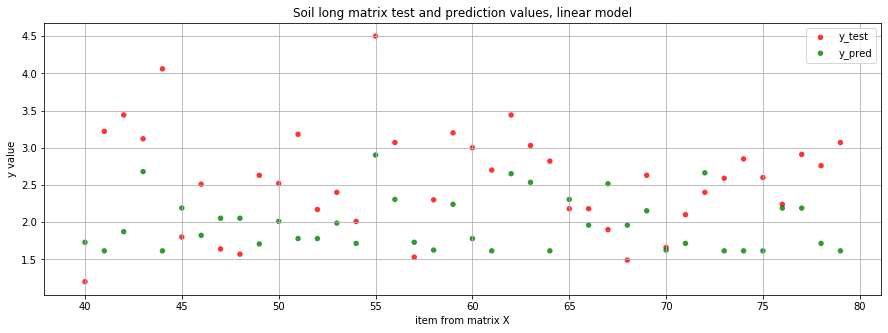

In [49]:
data = ((np.arange(40, 80), y_test.to_numpy().reshape(-1)[40:80]), (np.arange(40, 80), soil_long_pred[2].reshape(-1)[40:80]))
# data = ((np.arange(y_test[:40].shape[0]), y_test.to_numpy().reshape(-1)[:40]), (np.arange(y_test[:40].shape[0]), soil_long_pred[0].reshape(-1)[:40]))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Soil long matrix test and prediction values, linear model')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()

In [62]:
soil_long_mgua.buf_coef

[[[31, 198], [31, 210], [31, 1114], [31, 1590], [31, 1797], [210, 243]],
 [[171, 1], [171, 3], [706, 1], [1592, 1], [1592, 3], [1592, 4]],
 [[0, 0], [0, 3], [171, 2], [314, 5], [1592, 2], [2454, 5]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]],
 [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]]